## The problem and its unintuitive solution
Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

Now we might say "OK, if we can't solve something, could we try to approximate it? For example, if we could somehow draw samples from that posterior we can [Monte Carlo approximate](https://en.wikipedia.org/wiki/Monte_Carlo_method) it." Unfortunately, to directly sample from that distribution you not only have to solve Bayes formula, but also invert it, so that's even harder. 

The surprising insight though is that this is actually very easy and there exist a general class of algorithms that do this called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (constructing a Markov chain to do Monte Carlo approximation).

In [35]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

## Generate Observed Data

The parameters are mean = 0, Standard deviation  = 3 

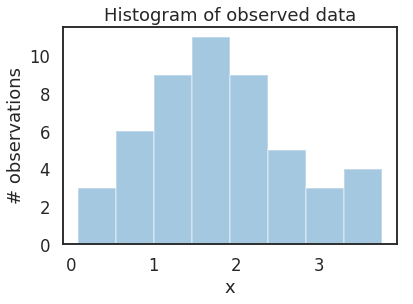

In [268]:
data = np.random.normal(loc=2, scale=1, size=50)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## The Problem

We'll assume we know that $\sigma = 1$ and we'll want to infer the posterior for $\mu$.

*  The data is normal distributed, i.e. the likelihood of the model is normal.

* For simplicity, lets also assume  a Normal distribution as a prior for $\mu$. Thus, 

In stats speak our model is:

$$\mu \sim \text{Normal}(0, 1)\\
x|\mu \sim \text{Normal}(x; \mu, 1)$$

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

In [269]:
mu_current = 5.
proposal_width = 1.

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler just takes a sample from a normal distribution centered around your current mu value with a certain standard deviation (proposal_width) that will determine how far you propose jumps.

In [270]:
mu_proposal = norm(mu_current, proposal_width).rvs()
mu_prior_mu=0.
mu_prior_sd=1.

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here).

In [271]:
def sampler(data, samples, mu_current, proposal_width = 1., plot=False, mu_prior_mu=0., mu_prior_sd=1.):
    posterior = [mu_current]
    cont_accepted = 0
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()
        
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1.).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1.).pdf(data).prod()

        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        # Nominator of Bayes formula
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept

        if accept:
            # Update position
            mu_current = mu_proposal
            cont_accepted += 1
            
        posterior.append(mu_current)
    return posterior

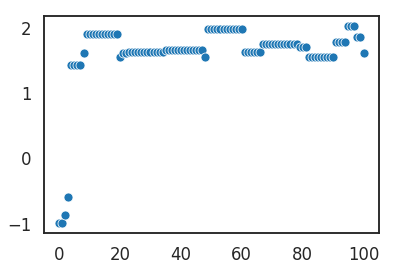

In [272]:
posterior = sampler(data, samples=100, mu_current=-1., mu_prior_mu=0., mu_prior_sd=0.5);
sns.scatterplot(data=np.array(posterior))
#fig, ax = plt.subplots()
#ax.plot(posterior)


### Why does this make sense?
Taking a step back, note that the above acceptance ratio is the reason this whole thing works out and we get around the integration. We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\mu_0$ is our current position, and $\mu$ is our proposal):

$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ -- that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability *relatively* more often than those of low posterior probability.


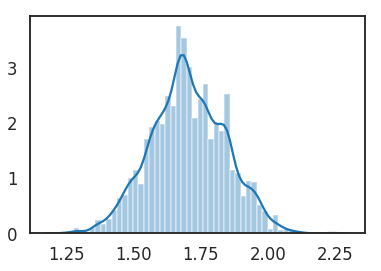

In [273]:
posterior = sampler(data, samples=10000, mu_current=-1., mu_prior_mu=0., mu_prior_sd=0.5);
sns.distplot(posterior[100:], label='estimated posterior')

## PYMC 3

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:02<00:00, 7885.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


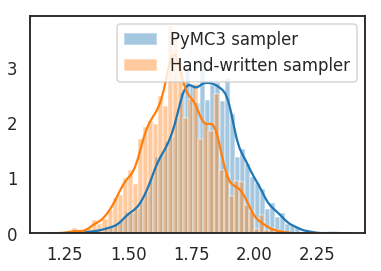

In [274]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(5000, step)
    
sns.distplot(trace[100:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[100:], label='Hand-written sampler');
plt.legend();

## Hamiltonian Montecarlo

Acceptance rate = 0.3318
Mean:  2.3507422231647617
Sigma: 0.001446985471439697
Acceptance rate = 0.6357364263573643
Mean:  2.350654487823931
Sigma: 0.0014185763980683697


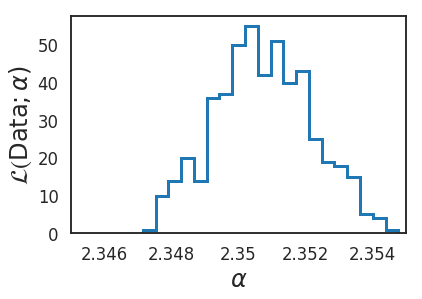

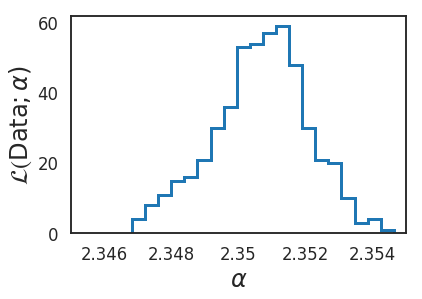

In [289]:
import numpy,math
import matplotlib.pyplot as plt
import random as random

random.seed(1)  # set random seed.

def sampleFromSalpeter(N, alpha, M_min, M_max):
	# Convert limits from M to logM.
	log_M_Min = math.log(M_min)
	log_M_Max = math.log(M_max)
	# Since Salpeter SMF decays, maximum likelihood occurs at M_min
	maxlik = math.pow(M_min, 1.0 - alpha)
	
	# Prepare array for output masses.
	Masses = []
	# Fill in array.
	while (len(Masses) < N):
		# Draw candidate from logM interval.
		logM = random.uniform(log_M_Min,log_M_Max)
		M    = math.exp(logM)
		# Compute likelihood of candidate from Salpeter SMF.
		likelihood = math.pow(M, 1.0 - alpha)
		# Accept randomly.
		u = random.uniform(0.0,maxlik)
		if (u < likelihood):
			Masses.append(M)
	return Masses

# Define logarithmic likelihood function.
# params ... array of fit params, here just alpha
# D      ... sum over log(M_n)
# N      ... number of data points.
# M_min  ... lower limit of mass interval
# M_max  ... upper limit of mass interval
def evaluateLogLikelihood(params, D, N, M_min, M_max):
      alpha = params[0]  # extract alpha
      # Compute normalisation constant.
      c = (1.0 - alpha)/(math.pow(M_max, 1.0-alpha) 
                          - math.pow(M_min, 1.0-alpha))
      # return log likelihood.
      return N*math.log(c) - alpha*D
  
# Generate toy data.
N      = 1000000  # Draw 1 Million stellar masses.
alpha  = 2.35
M_min  = 1.0
M_max  = 100.0
Masses = sampleFromSalpeter(N, alpha, M_min, M_max)
LogM   = numpy.log(numpy.array(Masses))
D      = numpy.mean(LogM)*N

# initial guess for alpha.
guess = [3.0]
# Prepare storing MCMC chain.
A = [guess]
# define stepsize of MCMC.
stepsizes = [0.005]
accepted  = 0.0

# Metropolis-Hastings with 10,000 iterations.
for n in range(10000):
      old_alpha  = A[len(A)-1]  # old parameter value.
      old_loglik = evaluateLogLikelihood(old_alpha, D, N, M_min, 
                      M_max)
      # Suggest new candidate from Gaussian proposal distribution.
      new_alpha = numpy.zeros([len(old_alpha)])
      for i in range(len(old_alpha)):
          new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
      new_loglik = evaluateLogLikelihood(new_alpha, D, N, M_min, 
                      M_max)
      # Accept new candidate in Monte-Carlo fashing.
      if (new_loglik > old_loglik):
          A.append(new_alpha)
          accepted = accepted + 1.0  # monitor acceptance
      else:
          u = random.uniform(0.0,1.0)
          if (u < math.exp(new_loglik - old_loglik)):
              A.append(new_alpha)
              accepted = accepted + 1.0  # monitor acceptance
          else:
              A.append(old_alpha)

print("Acceptance rate = "+str(accepted/10000.0))


# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(5000,10000):
      if (n % 10 == 0):
          Clean.append(A[n][0])

print("Mean:  "+str(numpy.mean(Clean)))
print("Sigma: "+str(numpy.std(Clean)))

plt.figure(1)
plt.hist(Clean, 20, histtype='step', lw=3)
plt.xticks([2.346,2.348,2.35,2.352,2.354],
             [2.346,2.348,2.35,2.352,2.354])
plt.xlim(2.345,2.355)
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
plt.savefig('example-MCMC-results.png')
#plt.show()

# Define gradient of log-likelihood.
def evaluateGradient(params, D, N, M_min, M_max, log_M_min, log_M_max):
    alpha = params[0]  # extract alpha
    grad = log_M_min*math.pow(M_min, 1.0-alpha) - log_M_max*math.pow(M_max, 1.0-alpha)
    grad = 1.0 + grad*(1.0 - alpha)/(math.pow(M_max, 1.0-alpha) - math.pow(M_min, 1.0-alpha))
    grad = -D - N*grad/(1.0 - alpha)
    return numpy.array(grad)

log_M_min  = math.log(1.0)
log_M_max  = math.log(100.0)
# Initial guess for alpha as array.
guess = [3.0]
# Prepare storing MCMC chain.
A = [guess]
# define stepsize of MCMC.
stepsize = 0.000047
accepted = 0.0

import copy
  
# Hamiltonian Monte-Carlo.
for n in range(10000):
      old_alpha  = A[len(A)-1]
      # Remember, energy = -loglik
      old_energy = -evaluateLogLikelihood(old_alpha, D, N, M_min, 
                        M_max)
      old_grad   = -evaluateGradient(old_alpha, D, N, M_min,  
                        M_max, log_M_min, log_M_max)
      
      new_alpha = copy.copy(old_alpha)  # deep copy of array
      new_grad  = copy.copy(old_grad)   # deep copy of array
      # Suggest new candidate using gradient + Hamiltonian dynamics.
      # draw random momentum vector from unit Gaussian.
      p = random.gauss(0.0, 1.0)
      H = numpy.dot(p,p)/2.0 + old_energy    # compute Hamiltonian
      
      # Do 5 Leapfrog steps.
      for tau in range(5):
          # make half step in p
          p         = p - stepsize*new_grad/2.0
          # make full step in alpha
          new_alpha = new_alpha + stepsize*p
          # compute new gradient
          new_grad  = -evaluateGradient(old_alpha, D, N, M_min,  
                           M_max, log_M_min, log_M_max)
          # make half step in p
          p         = p - stepsize*new_grad/2.0
      
      # Compute new Hamiltonian. Remember, energy = -loglik.
      new_energy = -evaluateLogLikelihood(new_alpha, D, N, M_min,
                       M_max)
      newH       = numpy.dot(p,p)/2.0 + new_energy
      dH         = newH - H
      
      # Accept new candidate in Monte-Carlo fashion.
      if (dH < 0.0):
          A.append(new_alpha)
          accepted = accepted + 1.0
      else:
          u = random.uniform(0.0,1.0)
          if (u < math.exp(-dH)):
              A.append(new_alpha)
              accepted = accepted + 1.0
          else:
              A.append(old_alpha)

print("Acceptance rate = "+str(accepted/float(len(A))))

# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(int(len(A)/2),len(A)):
    if (n % 10 == 0):
        Clean.append(A[n][0])

print("Mean:  "+str(numpy.mean(Clean)))
print("Sigma: "+str(numpy.std(Clean)))

plt.figure(2)
plt.hist(Clean, 20, histtype='step', lw=3)
plt.xticks([2.346,2.348,2.35,2.352,2.354],
           [2.346,2.348,2.35,2.352,2.354])
plt.xlim(2.345,2.355)
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
plt.savefig('example-HamiltonianMC-results.png')
plt.show()